In [1]:
import librosa
import librosa.display
import librosa.feature
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
# KNN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

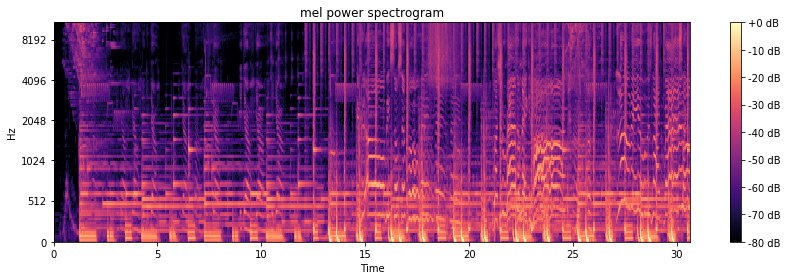

In [3]:
# Mel-Power Spectogram
y, sr = librosa.load('dataset/hiphop/hiphop.00040.wav')
spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
# convert to log scale (dB)
db_s = librosa.power_to_db(spect, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(db_s, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

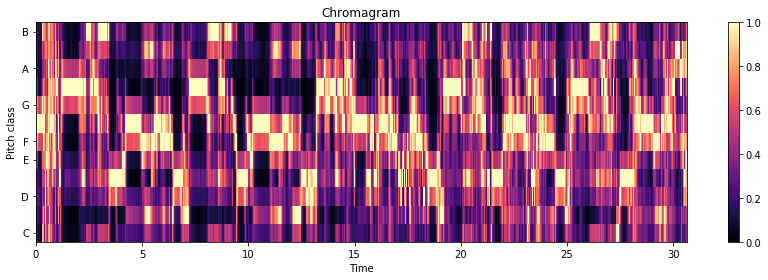

In [4]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

plt.figure(figsize=(12,4))
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram')
plt.colorbar()
plt.tight_layout()

In [9]:
# working w/ features from Spotify Web API

# retrieve access token
CLIENT_ID = 'ed4c681a60db443280abbe123c92585f'
CLIENT_SECRET = '8a4c55cf82d14c96b011179f37e47651'

def get_header(CLIENT_ID,CLIENT_SECRET):
    grant_type = 'client_credentials'
    params = {'grant_type': grant_type}

    url = 'https://accounts.spotify.com/api/token'
    response = requests.post(url, data=params, auth = (CLIENT_ID, CLIENT_SECRET))
    access_token = response.json()['access_token']
    headers = {'Authorization': f'Bearer {access_token}'}
    return headers

In [10]:
def get_playlist_track_ids(playlist_id):
    headers = get_header(CLIENT_ID, CLIENT_SECRET)
    playlist = requests.get(f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks', headers=headers).json()
    playlist = [s for s in playlist['items'] if s if s['track'] != None]
    track_ids = []

    for track in playlist:
        if ('id' in track['track'].keys()) and (type(track['track']) is dict):
            id = track['track']['id']
            track_ids.append(id)
    return track_ids

In [11]:
hip_hop = get_playlist_track_ids('37i9dQZF1DWY4xHQp97fN6')
classics = get_playlist_track_ids('37i9dQZF1DWWEJlAGA9gs0')
dance = get_playlist_track_ids('37i9dQZF1DX8tZsk68tuDw')
rock = get_playlist_track_ids('37i9dQZF1DWXRqgorJj26U')

In [12]:
print(len(hip_hop))
print(len(classics))
print(len(dance))
print(len(rock))

100
100
100
100


In [13]:
# get track features for each playlist
def get_playlist_track_features(track_ids, target):
    headers = get_header(CLIENT_ID, CLIENT_SECRET)
    joined_ids = ','.join(track_ids)
    r = requests.get(f"https://api.spotify.com/v1/audio-features/?ids={joined_ids}", headers=headers)
    features = r.json()
    df_playlist = pd.DataFrame(features['audio_features'])
    df_playlist['genre'] = target
    return df_playlist

In [14]:
df_hh = get_playlist_track_features(hip_hop, 'hip-hop')
df_classics = get_playlist_track_features(classics, 'classics')
df_dance = get_playlist_track_features(dance, 'dance')
df_rock = get_playlist_track_features(rock, 'rock')

In [15]:
# Combine all feature data
all_df = pd.concat([df_hh, df_classics, df_dance, df_rock])
all_df.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,genre
0,0.1890,https://api.spotify.com/v1/audio-analysis/6Ozh...,0.769,159715,0.787,6Ozh9Ok6h4Oi1wUSLtBseN,0.0,11,0.129,-3.909,1,0.3670,126.770,4,https://api.spotify.com/v1/tracks/6Ozh9Ok6h4Oi...,audio_features,spotify:track:6Ozh9Ok6h4Oi1wUSLtBseN,0.836,hip-hop
1,0.0933,https://api.spotify.com/v1/audio-analysis/5rav...,0.919,146600,0.556,5ravc2aiNoYmu9m37diYXW,0.0,4,0.109,-6.049,0,0.1640,130.025,4,https://api.spotify.com/v1/tracks/5ravc2aiNoYm...,audio_features,spotify:track:5ravc2aiNoYmu9m37diYXW,0.539,hip-hop
2,0.4440,https://api.spotify.com/v1/audio-analysis/5hDA...,0.753,123560,0.652,5hDAT527wXWNBnJlujhuUs,0.0,10,0.117,-5.943,0,0.0753,139.962,4,https://api.spotify.com/v1/tracks/5hDAT527wXWN...,audio_features,spotify:track:5hDAT527wXWNBnJlujhuUs,0.745,hip-hop
3,0.0177,https://api.spotify.com/v1/audio-analysis/598y...,0.882,183011,0.602,598yNsG1JFrGd4n2kMoz7F,0.0,11,0.178,-5.554,1,0.2450,142.959,4,https://api.spotify.com/v1/tracks/598yNsG1JFrG...,audio_features,spotify:track:598yNsG1JFrGd4n2kMoz7F,0.430,hip-hop
4,0.0687,https://api.spotify.com/v1/audio-analysis/6Gg1...,0.474,189323,0.631,6Gg1gjgKi2AK4e0qzsR7sd,0.0,5,0.132,-5.884,0,0.3430,180.051,4,https://api.spotify.com/v1/tracks/6Gg1gjgKi2AK...,audio_features,spotify:track:6Gg1gjgKi2AK4e0qzsR7sd,0.425,hip-hop


In [16]:
# select features
X = all_df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence']]
y = all_df.genre
%store X
%store y

Stored 'X' (DataFrame)
Stored 'y' (Series)


In [17]:
# scale features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

scaled_df = pd.DataFrame(X, columns=X.columns)
scaled_df.head()

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence
0,0.1890,0.769,0.787,0.0,11,0.129,-3.909,0.3670,126.770,4,0.836
1,0.0933,0.919,0.556,0.0,4,0.109,-6.049,0.1640,130.025,4,0.539
2,0.4440,0.753,0.652,0.0,10,0.117,-5.943,0.0753,139.962,4,0.745
3,0.0177,0.882,0.602,0.0,11,0.178,-5.554,0.2450,142.959,4,0.430
4,0.0687,0.474,0.631,0.0,5,0.132,-5.884,0.3430,180.051,4,0.425


In [18]:
# split data into training and test
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.2, random_state=3)

In [19]:
def find_best_k(X_tr, y_tr, X_te, y_te, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_tr, y_tr)
        preds = knn.predict(X_te)
        f1 = f1_score(y_te, preds, average='micro')
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [20]:
find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25)

Best Value for k: 1
F1-Score: 0.7250000000000001


In [21]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

In [22]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='micro')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='micro')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='micro')))
    
print_metrics(y_test, preds)

Precision Score: 0.725
Recall Score: 0.725
Accuracy Score: 0.725
F1 Score: 0.7250000000000001


In [23]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

    classics       0.96      0.96      0.96        24
       dance       0.67      0.75      0.71        16
     hip-hop       0.65      0.75      0.70        20
        rock       0.53      0.40      0.46        20

   micro avg       0.72      0.72      0.73        80
   macro avg       0.70      0.71      0.70        80
weighted avg       0.72      0.72      0.72        80



In [24]:
# try it with a massive Spotify dataset
massive_dataset = pd.read_csv('SpotifyFeatures.csv')
massive_dataset.head()

# select features
Xm = massive_dataset[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
ym = massive_dataset.genre

In [25]:
scaled_data = scaler.fit_transform(Xm)

scaled_m_df = pd.DataFrame(Xm, columns=Xm.columns)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(scaled_m_df, ym, test_size=0.2, random_state=3)

In [26]:
find_best_k(Xm_train, ym_train, Xm_test, ym_test, min_k=1, max_k=25)

Best Value for k: 25
F1-Score: 0.2076055430228811


In [27]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(Xm_train, ym_train)
preds_m = knn.predict(Xm_test)

In [28]:
print_metrics(ym_test, preds_m)

Precision Score: 0.2076055430228811
Recall Score: 0.2076055430228811
Accuracy Score: 0.2076055430228811
F1 Score: 0.2076055430228811


In [29]:
print(classification_report(ym_test, preds_m))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        22
     Alternative       0.06      0.08      0.07      1861
           Anime       0.19      0.24      0.21      1756
           Blues       0.11      0.13      0.12      1837
Children's Music       0.20      0.20      0.20      1090
Children’s Music       0.04      0.04      0.04      1830
       Classical       0.33      0.48      0.39      1817
          Comedy       0.89      0.85      0.87      1936
         Country       0.09      0.15      0.11      1744
           Dance       0.11      0.16      0.13      1734
      Electronic       0.33      0.34      0.33      1847
            Folk       0.10      0.13      0.11      1878
         Hip-Hop       0.15      0.15      0.15      1860
           Indie       0.06      0.04      0.05      1936
            Jazz       0.19      0.17      0.18      1886
           Movie       0.12      0.07      0.09      1585
           Op